In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
import string
import unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

df = pd.read_csv('train.csv')

print(df.head())


   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Prikaz distribucije podataka

In [ ]:
df['label'] = df['class'].apply(lambda x: 1 if x == 1 else 0)
df = df[['tweet', 'label']]
def plot_distribution(data, column):
    class_counts = data[column].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribucija klasa')
    plt.xlabel('Klasa (0 = Nije govor mržnje, 1 = Govor mržnje)')
    plt.ylabel('Broj primera')
    plt.show()

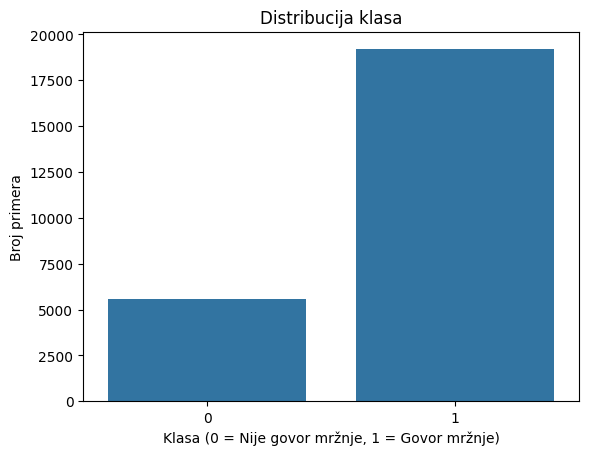

In [3]:
plot_distribution(df, 'label')

#### Preprocesiranje teksta

In [ ]:
def preprocess_text(df, text_column):
    """
    Funkcija za predobradu teksta.
    
    Argumenti:
    - df: Pandas DataFrame koji sadrži kolonu sa tekstom.
    - text_column: Ime kolone koja sadrži tekstualne podatke.
    
    Vraća:
    - df: Pandas DataFrame sa novom kolonom 'clean_text' koja sadrži predobrađen tekst.
    """
    df = df.copy()
    
    # Uklanjanje URL-ova i email adresa
    df['clean_tweet'] = df[text_column].apply(lambda x: re.sub(r'http\S+|www.\S+|mailto:\S+', '', x))
    
    # Uklanjanje HTML tagova
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
    
    # Uklanjanje emotikona i specijalnih karaktera
    def remove_emojis(text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emotikoni
                                   u"\U0001F300-\U0001F5FF"  # simobli i ikone
                                   u"\U0001F680-\U0001F6FF"  # transport i simobli
                                   u"\U0001F1E0-\U0001F1FF"  # zastave
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    df['clean_tweet'] = df['clean_tweet'].apply(remove_emojis)
    
    # Uklanjanje specijalnih karaktera i interpunkcije
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^A-Za-zšđčćžŠĐČĆŽ ]+', ' ', x))
    
    # Pretvaranje u mala slova
    df['clean_tweet'] = df['clean_tweet'].str.lower()
    
    # Uklanjanje dijakritika
    def remove_diacritics(text):
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        return text

    df['clean_tweet'] = df['clean_tweet'].apply(remove_diacritics)
    
    # Uklanjanje višestrukih razmaka
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('\s+', ' ', x).strip())
    
    # Tokenizacija
    df['tokens'] = df['clean_tweet'].apply(nltk.word_tokenize)
    
    # Uklanjanje stop-reči
    stop_words = set(stopwords.words('english'))  # Ako imaš stop-reči za srpski, zameni ovde
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Lematizacija
    lemmatizer = WordNetLemmatizer()
    df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # Spajanje tokena nazad u string
    df['clean_tweet'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    # Uklanjanje nepotrebnih kolona
    df = df.drop(columns=['tokens'])
    
    return df


In [5]:
data = preprocess_text(df, 'tweet')

print(data.head())

C:\Users\Kaca\AppData\Local\Temp\ipykernel_8152\2996977020.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['clean_tweet'] = df['clean_tweet'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())


                                               tweet  label  \
0  !!! RT @mayasolovely: As a woman you shouldn't...      0   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1   

                                         clean_tweet  
0  rt mayasolovely woman complain cleaning house ...  
1  rt mleew boy dat cold tyga dwn bad cuffin dat ...  
2  rt urkindofbrand dawg rt sbaby life ever fuck ...  
3        rt c g anderson viva based look like tranny  
4  rt shenikaroberts shit hear might true might f...  


#### Definisanje metoda mašinskog učenja

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test):
    print("Logistička regresija: ")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model

def train_svm(X_train, y_train, X_test, y_test):
    print("SVM: ")
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model

def train_naive_bayes(X_train, y_train, X_test, y_test):
    print("Naive Bayes: ")
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model


#### Definisanje neuronskih mreža

In [ ]:
def prepare_tokenizer(texts, num_words=5000):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def tokenize_and_pad(tokenizer, texts, maxlen=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen)
    return padded

def train_lstm(X_train, y_train, X_test, y_test, vocab_size, maxlen=100):
    print("LSTM: ")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'LSTM Test Accuracy: {accuracy}')
    
    return model

def train_cnn(X_train, y_train, X_test, y_test, vocab_size, maxlen=100):
    print("CNN: ")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'CNN Test Accuracy: {accuracy}')
    return model


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test, model_type='sklearn', tokenizer=None, maxlen=100):
    """
    Evaluira model i prikazuje metrike performansi.
    
    Argumenti:
    - model: istrenirani model
    - X_test: test podaci (tekstualni ili vektorski)
    - y_test: stvarne labela
    - model_type: 'sklearn', 'keras', ili 'bert'
    - tokenizer: Tokenizer objekat (potreban za neuronske mreže)
    - maxlen: maksimalna dužina sekvenci (za neuronske mreže)
    """
    if model_type == 'sklearn':
        y_pred = model.predict(X_test)
    elif model_type == 'keras':
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
    elif model_type == 'bert':
        y_pred = model.predict(X_test).logits
        y_pred = np.argmax(y_pred, axis=1)
    else:
        raise ValueError("Nepoznat tip modela.")
    
    print("Izveštaj o klasifikaciji:")
    print(classification_report(y_test, y_pred))
    print("Matrica konfuzije:")
    print(confusion_matrix(y_test, y_pred))


### Definisanje funkcija za primenu metoda

In [9]:
def create_vectorizer(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    return X_train_vec, X_test_vec

def create_tokenizer(X_train, X_test):
    tokenizer = prepare_tokenizer(X_train, num_words=5000)
    X_train_seq = tokenize_and_pad(tokenizer, X_train)
    X_test_seq = tokenize_and_pad(tokenizer, X_test)
    vocab_size = len(tokenizer.word_index) + 1  

    return X_train_seq, X_test_seq, vocab_size

In [10]:
def train_classification_models(X_train_vec, y_train, X_test_vec, y_test):
    lr_model = train_logistic_regression(X_train_vec, y_train, X_test_vec, y_test)
    evaluate_model(lr_model, X_test_vec, y_test, model_type='sklearn')

    svm_model = train_svm(X_train_vec, y_train, X_test_vec, y_test)
    evaluate_model(svm_model, X_test_vec, y_test, model_type='sklearn')

    nb_model = train_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
    evaluate_model(nb_model, X_test_vec, y_test, model_type='sklearn')

def train_neural_networks(X_train_seq, y_train, X_test_seq, y_test, vocab_size):
    lstm_model = train_lstm(X_train_seq, y_train, X_test_seq, y_test, vocab_size)
    evaluate_model(lstm_model, X_test_seq, y_test, model_type='keras')

    cnn_model = train_cnn(X_train_seq, y_train, X_test_seq, y_test, vocab_size)
    evaluate_model(cnn_model, X_test_seq, y_test, model_type='keras')

In [11]:
def run(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_vec, X_test_vec = create_vectorizer(X_train, X_test)
    X_train_seq, X_test_seq, vocab_size = create_tokenizer(X_train, X_test)

    train_classification_models(X_train_vec, y_train, X_test_vec, y_test)
    train_neural_networks(X_train_seq, y_train, X_test_seq, y_test, vocab_size)

### Primena algoritama nad originalnim podacima

In [12]:
X = data['clean_tweet']
y = data['label']

run(X, y)

Logistička regresija: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1125
           1       0.92      0.95      0.93      3832

    accuracy                           0.90      4957
   macro avg       0.86      0.84      0.85      4957
weighted avg       0.89      0.90      0.90      4957

Matrica konfuzije:
[[ 814  311]
 [ 197 3635]]
SVM: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1125
           1       0.93      0.95      0.94      3832

    accuracy                           0.90      4957
   macro avg       0.87      0.85      0.86      4957
weighted avg       0.90      0.90      0.90      4957

Matrica konfuzije:
[[ 845  280]
 [ 205 3627]]
Naive Bayes: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.87      0.37      0.52      1125
           1       0.84 

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.8365 - loss: 0.3830 - val_accuracy: 0.9080 - val_loss: 0.2445
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - accuracy: 0.9286 - loss: 0.2015 - val_accuracy: 0.9056 - val_loss: 0.2485
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.9401 - loss: 0.1800 - val_accuracy: 0.9001 - val_loss: 0.2647
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.9482 - loss: 0.1529 - val_accuracy: 0.8987 - val_loss: 0.2954
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.9551 - loss: 0.1312 - val_accuracy: 0.8903 - val_loss: 0.3390
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8923 - loss: 0.3291
LSTM Test Accuracy: 0.8902562260627747
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1125
           1       0.92      0.94      0.93      3832

    accuracy 

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8298 - loss: 0.3970 - val_accuracy: 0.9042 - val_loss: 0.2574
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.9316 - loss: 0.2045 - val_accuracy: 0.8971 - val_loss: 0.2661
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.9504 - loss: 0.1517 - val_accuracy: 0.8901 - val_loss: 0.3178
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9733 - loss: 0.0840 - val_accuracy: 0.8786 - val_loss: 0.4070
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9830 - loss: 0.0494 - val_accuracy: 0.8701 - val_loss: 0.4993
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8715 - loss: 0.4903
CNN Test Accuracy: 0.8700827360153198
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1125
           1       0.90      0.94      0.92      3832

    accuracy         

### Augmentacija podataka

### Definisanje metoda augmentacije podataka

#### Metode augmentacije na nivou karaktera

In [14]:
def simulate_spelling_errors(text, error_prob=0.1):
    """
    Simulira pravopisne greške u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti izmenjen.
    
    Vraća:
    - Tekst sa simuliranim pravopisnim greškama.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    result = ''
    for c in text:
        if c.lower() in letters and random.random() < error_prob:
            result += random.choice(letters)
        else:
            result += c
    return result


In [15]:
def keyboard_augmenter(text, error_prob=0.1):
    """
    Simulira greške u kucanju na osnovu rasporeda tastature.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti zamenjen.
    
    Vraća:
    - Tekst sa simuliranim greškama u kucanju.
    """
    keyboard_neighbors = {
        'a': 'qwsz',
        'b': 'vghn',
        'c': 'xdfv',
        'd': 'ersfcx',
        'e': 'wsdfr',
        'f': 'rtgdvc',
        'g': 'tyfhvb',
        'h': 'yugjbn',
        'i': 'ujklo',
        'j': 'uikhmn',
        'k': 'ijolm,',
        'l': 'kop;.',
        'm': 'njk,',
        'n': 'bhjm',
        'o': 'iklp',
        'p': 'ol;',
        'q': 'wa',
        'r': 'edft',
        's': 'wedxz',
        't': 'rfgy',
        'u': 'yhji',
        'v': 'cfgb',
        'w': 'qase',
        'x': 'zsdc',
        'y': 'tghu',
        'z': 'asx'
    }
    result = ''
    for c in text:
        lower_c = c.lower()
        if lower_c in keyboard_neighbors and random.random() < error_prob:
            result += random.choice(keyboard_neighbors[lower_c])
        else:
            result += c
    return result


In [16]:
def ocr_simulation(text, error_prob=0.05):
    """
    Simulira OCR greške u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti zamenjen.
    
    Vraća:
    - Tekst sa simuliranim OCR greškama.
    """
    ocr_errors = {
        '0': ['O', 'o'],
        '1': ['I', 'l'],
        'l': ['1', 'I'],
        'O': ['0', 'o'],
        'o': ['0', 'O'],
        'I': ['1', 'l']
    }
    result = ''
    for c in text:
        if c in ocr_errors and random.random() < error_prob:
            result += random.choice(ocr_errors[c])
        else:
            result += c
    return result


In [17]:
def random_character_augmentation(text, aug_prob=0.1):
    """
    Nasumična augmentacija karaktera u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - aug_prob: Verovatnoća da će svaka operacija biti primenjena na karakter.
    
    Vraća:
    - Augmentirani tekst.
    """
    functions = [delete_random_char, substitute_random_char, swap_random_chars, insert_random_char]
    augmented_text = text
    for func in functions:
        augmented_text = func(augmented_text, aug_prob)
    return augmented_text

def delete_random_char(text, aug_prob):
    result = ''
    for c in text:
        if random.random() > aug_prob:
            result += c
    return result

def substitute_random_char(text, aug_prob):
    letters = string.ascii_letters
    result = ''
    for c in text:
        if random.random() < aug_prob:
            result += random.choice(letters)
        else:
            result += c
    return result

def swap_random_chars(text, aug_prob):
    text = list(text)
    for i in range(len(text)-1):
        if random.random() < aug_prob:
            text[i], text[i+1] = text[i+1], text[i]
    return ''.join(text)

def insert_random_char(text, aug_prob):
    result = ''
    letters = string.ascii_letters
    for c in text:
        result += c
        if random.random() < aug_prob:
            result += random.choice(letters)
    return result


#### Metode augmentacije na nivou reči

In [18]:
def synonym_replacement(text, n=2):
    """
    Zamenjuje n reči njihovim sinonimima.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    
    Vraća:
    - Tekst sa zamenjenim sinonimima.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    augmented_text = ' '.join(new_words)
    return augmented_text

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            synonym = lem.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)


In [19]:
def antonym_replacement(text, n=2):
    """
    Zamenjuje n reči njihovim antonimima.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    
    Vraća:
    - Tekst sa zamenjenim antonimima.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        antonyms = get_antonyms(random_word)
        if len(antonyms) >= 1:
            antonym = random.choice(antonyms)
            new_words = [antonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    augmented_text = ' '.join(new_words)
    return augmented_text

def get_antonyms(word):
    antonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            for ant in lem.antonyms():
                antonym = ant.name().replace('_', ' ').lower()
                antonyms.add(antonym)
    return list(antonyms)


In [20]:
def random_insertion(text, n=2):
    """
    Umeće n sinonima nasumično u tekst.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti umetnute.
    
    Vraća:
    - Tekst sa umetnutim rečima.
    """
    words = text.split()
    for _ in range(n):
        add_word(words)
    augmented_text = ' '.join(words)
    return augmented_text

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
    if len(synonyms) >= 1:
        synonym = random.choice(synonyms)
        random_idx = random.randint(0, len(words))
        words.insert(random_idx, synonym)


In [21]:
def random_swap(text, n=2):
    """
    Menja mesta dvema rečima u tekstu n puta.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj zamena.
    
    Vraća:
    - Tekst sa zamenjenim rečima.
    """
    words = text.split()
    for _ in range(n):
        words = swap_word(words)
    augmented_text = ' '.join(words)
    return augmented_text

def swap_word(words):
    idx1 = random.randint(0, len(words)-1)
    idx2 = random.randint(0, len(words)-1)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words


In [22]:
def random_deletion(text, p=0.2):
    """
    Briše reči iz teksta sa verovatnoćom p.
    
    Argumenti:
    - text: Originalni tekst.
    - p: Verovatnoća brisanja reči.
    
    Vraća:
    - Tekst sa obrisanim rečima.
    """
    words = text.split()
    if len(words) == 1:
        return text
    new_words = []
    for word in words:
        if random.uniform(0,1) > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words)
    else:
        return ' '.join(new_words)


In [23]:
def split_augmentation(text, n=2):
    """
    Deli n reči na manje delove.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti podeljene.
    
    Vraća:
    - Tekst sa podeljenim rečima.
    """
    words = text.split()
    new_words = words.copy()
    num_splits = 0
    while num_splits < n:
        idx = random.randint(0, len(new_words)-1)
        word = new_words[idx]
        if len(word) > 1:
            split_point = random.randint(1, len(word)-1)
            new_words[idx:idx+1] = [word[:split_point], word[split_point:]]
            num_splits += 1
        if num_splits >= n:
            break
    return ' '.join(new_words)


In [24]:
def spelling_augmentation(text, error_prob=0.1):
    """
    Umeće pravopisne greške u reči.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će reč biti izmenjena.
    
    Vraća:
    - Tekst sa pravopisnim greškama.
    """
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < error_prob:
            new_word = random_character_augmentation(word, aug_prob=0.2)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


#### Metode augmentacije na nivu fraza i rečenica

In [25]:
def random_sentence_augmentation(text):
    """
    Nasumično menja redosled rečenica u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    
    Vraća:
    - Tekst sa promenjenim redosledom rečenica.
    """
    sentences = nltk.sent_tokenize(text)
    random.shuffle(sentences)
    return ' '.join(sentences)


#### Primena metoda nad augmentiranim podacima

In [ ]:
from tqdm import tqdm
def augment_dataset(df, text_column, method, num_augmented_instances, **kwargs):
    """
    Primeni izabranu metodu augmentacije na dataset.
    
    Argumenti:
    - df: Originalni DataFrame.
    - text_column: Naziv kolone sa tekstom.
    - method: Funkcija metode augmentacije.
    - num_augmented_instances: Broj instanci koje treba generisati.
    - **kwargs: Dodatni argumenti za metodu augmentacije.
    
    Vraća:
    - DataFrame sa augmentiranim podacima.
    """
    augmented_texts = []
    indices = df.index.tolist()
    num_samples = len(indices)
    
    replace = num_augmented_instances > num_samples
    sampled_indices = np.random.choice(indices, size=num_augmented_instances, replace=replace)
    
    for idx in tqdm(sampled_indices, desc=f'Augmenting with {method.__name__}'):
        original_text = df.loc[idx, text_column]
        augmented_text = method(original_text, **kwargs)
        augmented_texts.append(augmented_text)
    
    augmented_df = pd.DataFrame({text_column: augmented_texts})
    return augmented_df


#### Augmentirani dataset 1

In [28]:
import pandas as pd

all_methods = [simulate_spelling_errors, keyboard_augmenter, ocr_simulation, random_character_augmentation, synonym_replacement, antonym_replacement, random_insertion, random_swap, random_deletion, split_augmentation, spelling_augmentation, random_sentence_augmentation]
met1= [simulate_spelling_errors, synonym_replacement, random_sentence_augmentation, split_augmentation]

negative_class_df = data[data['label'] == 0]

num_class_0 = len(negative_class_df)
num_class_1 = len(data[data['label'] == 1])

class_difference = abs(num_class_0 - num_class_1)

num_methods = len(met1)

split_dataframes = np.array_split(negative_class_df, num_methods)

num_instances_per_method = class_difference // num_methods

augmented_dfs = []
for method, split_df in zip(met1, split_dataframes):
    augmented_df = augment_dataset(
        split_df, 
        text_column='clean_tweet', 
        method=method, 
        num_augmented_instances=num_instances_per_method
    )
    augmented_df['label'] = 0
    augmented_dfs.append(augmented_df)

final_augmented_df = pd.concat(augmented_dfs, ignore_index=True)

final = pd.concat([data, final_augmented_df], ignore_index=True)

print(final)


Augmenting with split_augmentation: 100%|██████████| 3399/3399 [00:00<00:00, 68624.04it/s]

                                                   tweet  label  \
0      !!! RT @mayasolovely: As a woman you shouldn't...      0   
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1   
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1   
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1   
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1   
...                                                  ...    ...   
38374                                                NaN      0   
38375                                                NaN      0   
38376                                                NaN      0   
38377                                                NaN      0   
38378                                                NaN      0   

                                             clean_tweet  
0      rt mayasolovely woman complain cleaning house ...  
1      rt mleew boy dat cold tyga dwn bad cuffin dat ...  
2      rt urkindof

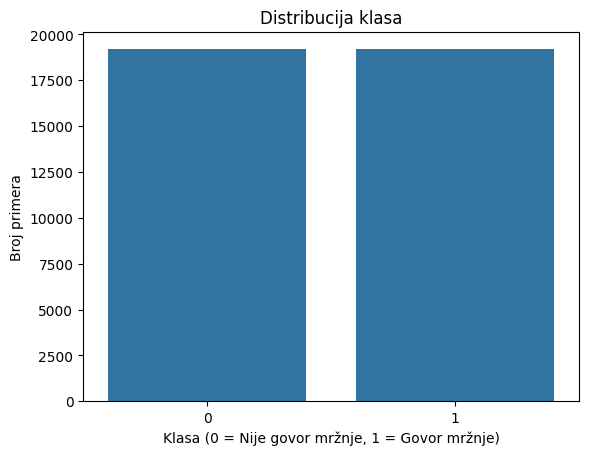

In [29]:
plot_distribution(final, 'label')

In [30]:
num_class_0f = len(final[final['label'] == 0])
num_class_1f = len(final[final['label'] == 1])

print(num_class_0f, num_class_1f)

19189 19190


In [31]:
final = pd.concat([data, final_augmented_df], ignore_index=True)
df_augmented_set1 = final
df_augmented_set1

,tweet,label,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,rt mayasolovely woman complain cleaning house ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,rt mleew boy dat cold tyga dwn bad cuffin dat ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,rt urkindofbrand dawg rt sbaby life ever fuck ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,rt c g anderson viva based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,rt shenikaroberts shit hear might true might f...
...,...,...,...
38374,NaN,0,s wap meet bo und beaner
38375,NaN,0,ruffled ntac eileen dah lia beautiful co lor c...
38376,NaN,0,rt cigars nsc otch black yellow going win year...
38377,NaN,0,dem b ir d


In [32]:
X_aug1 = df_augmented_set1['clean_tweet']
y_aug1 = df_augmented_set1['label']

run(X_aug1, y_aug1)

Logistička regresija: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3877
           1       0.92      0.89      0.91      3799

    accuracy                           0.91      7676
   macro avg       0.91      0.91      0.91      7676
weighted avg       0.91      0.91      0.91      7676

Matrica konfuzije:
[[3586  291]
 [ 405 3394]]
SVM: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3877
           1       0.95      0.90      0.92      3799

    accuracy                           0.93      7676
   macro avg       0.93      0.93      0.93      7676
weighted avg       0.93      0.93      0.93      7676

Matrica konfuzije:
[[3678  199]
 [ 361 3438]]
Naive Bayes: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3877
           1       0.82 

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


480/480 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.8435 - loss: 0.3861 - val_accuracy: 0.9108 - val_loss: 0.2500
Epoch 2/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - accuracy: 0.9253 - loss: 0.2119 - val_accuracy: 0.9125 - val_loss: 0.2431
Epoch 3/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.9406 - loss: 0.1696 - val_accuracy: 0.9196 - val_loss: 0.2249
Epoch 4/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 373s 779ms/step - accuracy: 0.9522 - loss: 0.1278 - val_accuracy: 0.9243 - val_loss: 0.2244
Epoch 5/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.9617 - loss: 0.1039 - val_accuracy: 0.9254 - val_loss: 0.2353
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9192 - loss: 0.2478
LSTM Test Accuracy: 0.9253517389297485
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3877
           1       0.92      0.93      0.92      3799

    accuracy

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


480/480 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.8154 - loss: 0.4175 - val_accuracy: 0.9104 - val_loss: 0.2489
Epoch 2/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.9335 - loss: 0.1888 - val_accuracy: 0.9191 - val_loss: 0.2255
Epoch 3/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.9639 - loss: 0.1138 - val_accuracy: 0.9203 - val_loss: 0.2425
Epoch 4/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.9787 - loss: 0.0651 - val_accuracy: 0.9091 - val_loss: 0.2910
Epoch 5/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.9852 - loss: 0.0459 - val_accuracy: 0.9125 - val_loss: 0.3298
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9054 - loss: 0.3578
CNN Test Accuracy: 0.9124544262886047
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3877
           1       0.92      0.90      0.91      3799

    accuracy         

#### Augmentirani dataset 2

In [33]:
augmented_data = pd.read_csv('fully_augmented_train.csv')
augmented_df2 = augmented_data[['clean_tweet', 'label']]
augmented_df2 = augmented_df2.dropna()

In [34]:
num_class_0f = len(augmented_df2[augmented_df2['label'] == 0])
num_class_1f = len(augmented_df2[augmented_df2['label'] == 1])

print(num_class_0f, num_class_1f)

22133 19190


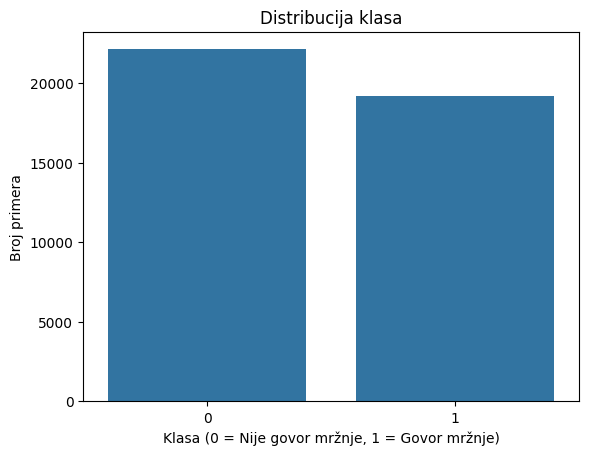

In [35]:
plot_distribution(augmented_df2, 'label')

In [36]:
X_aug2 = augmented_df2['clean_tweet']
y_aug2 = augmented_df2['label']

run(X_aug2, y_aug2)


Logistička regresija: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      4465
           1       0.92      0.88      0.90      3800

    accuracy                           0.91      8265
   macro avg       0.91      0.90      0.91      8265
weighted avg       0.91      0.91      0.91      8265

Matrica konfuzije:
[[4163  302]
 [ 467 3333]]
SVM: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4465
           1       0.95      0.90      0.93      3800

    accuracy                           0.93      8265
   macro avg       0.94      0.93      0.93      8265
weighted avg       0.94      0.93      0.93      8265

Matrica konfuzije:
[[4293  172]
 [ 371 3429]]
Naive Bayes: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      4465
           1       0.83 

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 182ms/step - accuracy: 0.8311 - loss: 0.3958 - val_accuracy: 0.9091 - val_loss: 0.2473
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 98s 190ms/step - accuracy: 0.9211 - loss: 0.2134 - val_accuracy: 0.9174 - val_loss: 0.2208
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 94s 181ms/step - accuracy: 0.9392 - loss: 0.1592 - val_accuracy: 0.9244 - val_loss: 0.2121
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 102s 198ms/step - accuracy: 0.9539 - loss: 0.1217 - val_accuracy: 0.9262 - val_loss: 0.2181
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.9651 - loss: 0.0959 - val_accuracy: 0.9306 - val_loss: 0.2286
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9298 - loss: 0.2266
LSTM Test Accuracy: 0.9305505156517029
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      4465
           1       0.94      0.90      0.92      3800

    accuracy

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


517/517 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.8062 - loss: 0.4136 - val_accuracy: 0.9055 - val_loss: 0.2455
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.9314 - loss: 0.1880 - val_accuracy: 0.9197 - val_loss: 0.2328
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.9650 - loss: 0.1020 - val_accuracy: 0.9206 - val_loss: 0.2474
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.9823 - loss: 0.0570 - val_accuracy: 0.9245 - val_loss: 0.2721
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9885 - loss: 0.0361 - val_accuracy: 0.9191 - val_loss: 0.3280
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9177 - loss: 0.3522
CNN Test Accuracy: 0.919056236743927
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4465
           1       0.94      0.89      0.91      3800

    accuracy          

C:\Users\Kaca\AppData\Local\Temp\ipykernel_8152\1219250864.py:61: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(data=accuracy_df, x='Model', y='Tačnost', hue='Dataset', palette=palette)


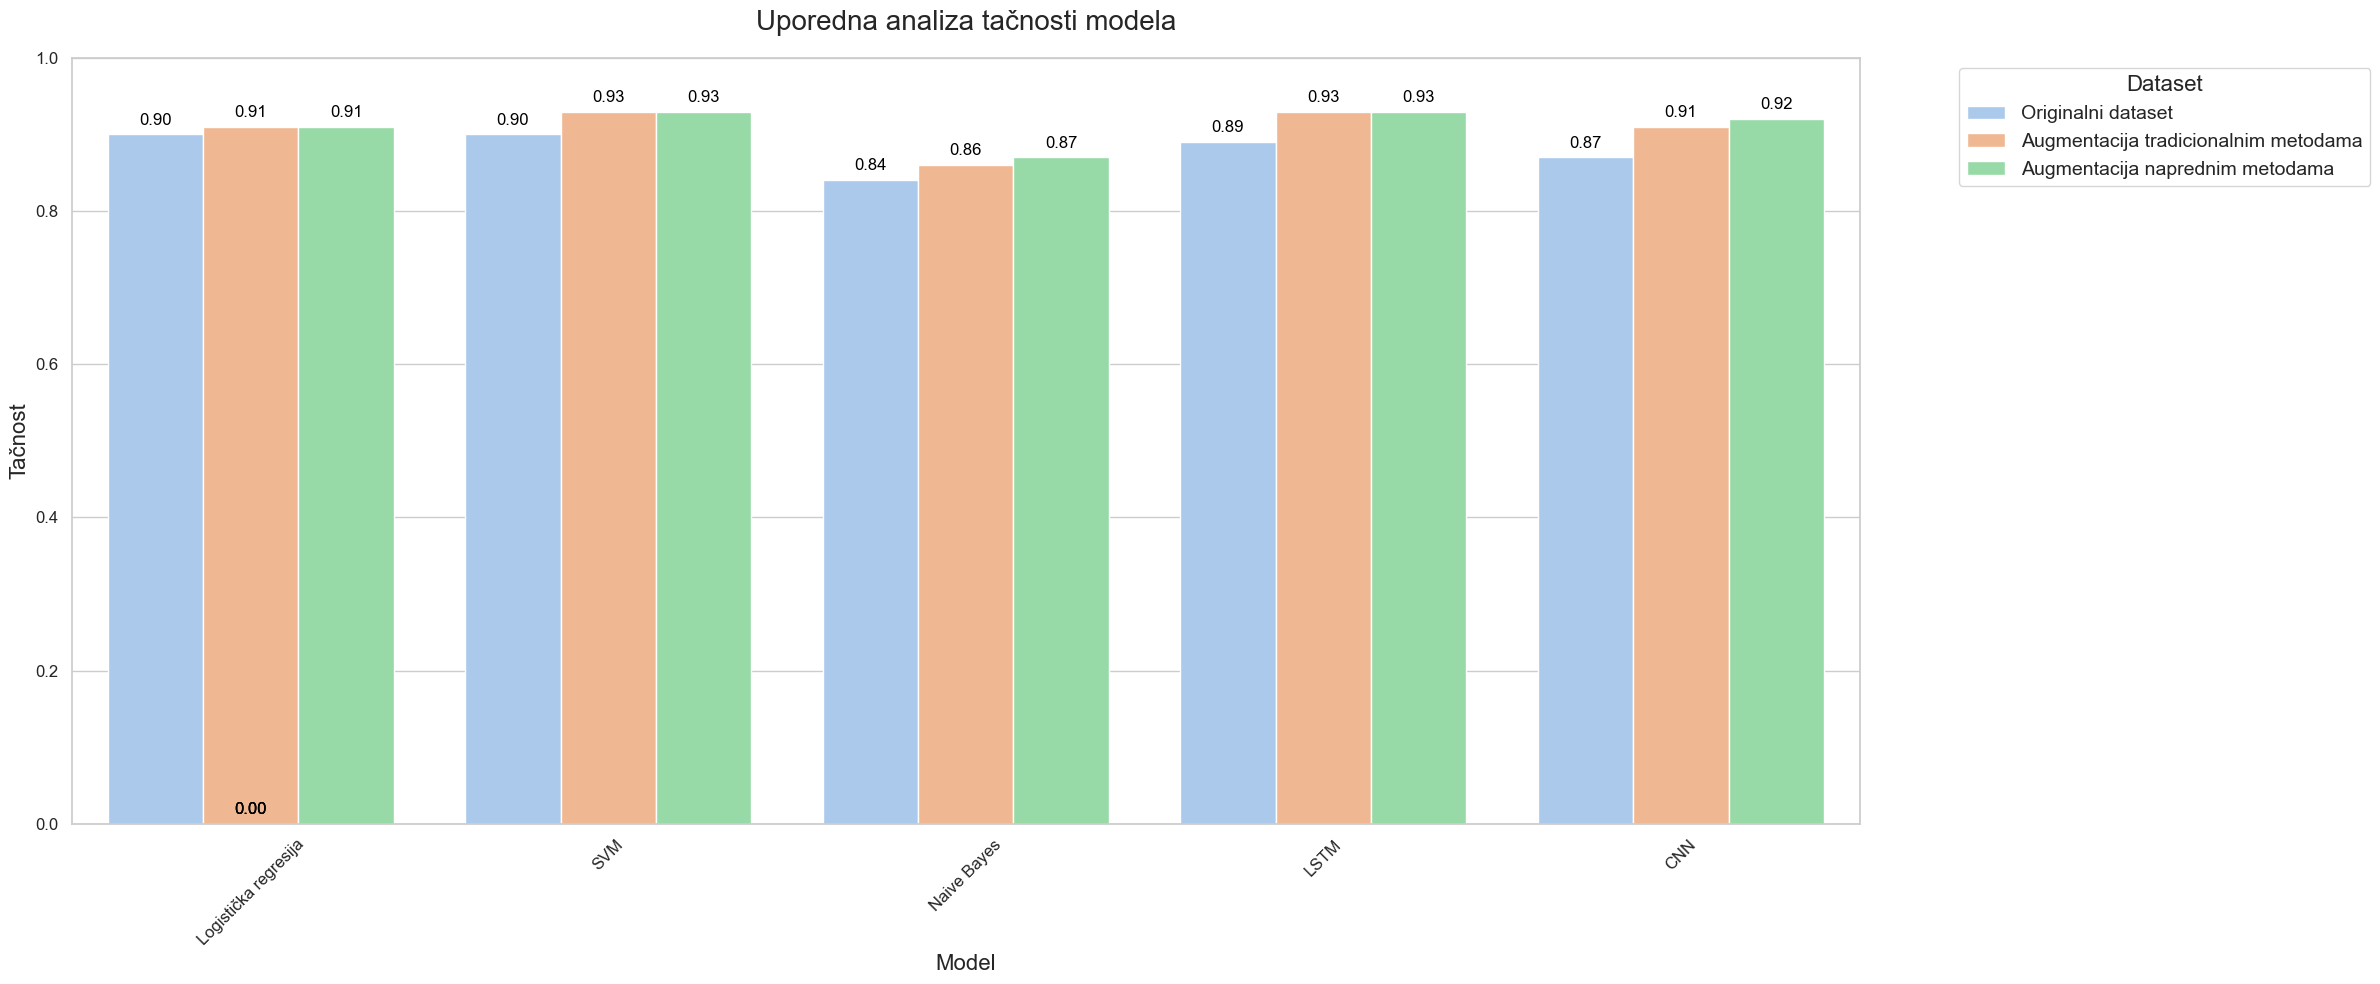

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

models = ['Logistička regresija', 'SVM', 'Naive Bayes', 'LSTM', 'CNN']

data1 = {
    'Model': models,
    'Tačnost': [0.90, 0.90, 0.84, 0.89, 0.87]
}

data2 = {
    'Model': models,
    'Tačnost': [0.91, 0.93, 0.86, 0.93, 0.91]
}

data3 = {
    'Model': models,
    'Tačnost': [0.91, 0.93, 0.87, 0.93, 0.92]
}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

df1['Dataset'] = 'Originalni dataset'
df2['Dataset'] = 'Augmentacija tradicionalnim metodama'
df3['Dataset'] = 'Augmentacija naprednim metodama'

df = pd.concat([df1, df2, df3], ignore_index=True)
accuracy_df = df.copy()
plt.figure(figsize=(24, 10))

palette = sns.color_palette("pastel")
ax = sns.barplot(data=accuracy_df, x='Model', y='Tačnost', hue='Dataset', palette=palette)

plt.title('Uporedna analiza tačnosti modela', fontsize=20, pad=20)
plt.ylabel('Tačnost', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylim(0, 1)

plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()
